In [1]:
import time

In [1]:
import os
import tensorflow as tf 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
import tensorboard

In [2]:
import os, glob
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from datagen import clf_generator
mirrored_strategy = tf.distribute.MirroredStrategy(devices=['/device:GPU:1', '/device:GPU:2'])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [3]:
BASE_PATH = shuffle(glob.glob('/home/centos/jupyter/pathology/patch_overlap_global_512_stain/*/*'),random_state=311)# all patients
SAVE_PATH='./model/clf_0707_01.hdf5'
TRAIN_PATIENT_PATH = BASE_PATH[:int(0.6*len(BASE_PATH))]
VALID_PATIENT_PATH = BASE_PATH[int(0.8*len(BASE_PATH)):int(0.8*len(BASE_PATH))]
TEST_PATIENT_PATH = BASE_PATH[int(0.8*len(BASE_PATH)):]
TRAIN_IMG_PATH = []
for x in TRAIN_PATIENT_PATH:
    TRAIN_IMG_PATH.extend(list(zip(glob.glob(x+'/image/*.png'),glob.glob(x+'/mask/*.png'))))
    
VALID_IMG_PATH = []
for x in VALID_PATIENT_PATH:
    VALID_IMG_PATH.extend(list(zip(glob.glob(x+'/image/*.png'),glob.glob(x+'/mask/*.png'))))
    
TEST_IMG_PATH = []
for x in TEST_PATIENT_PATH:
    TEST_IMG_PATH.extend(list(zip(glob.glob(x+'/image/*.png'),glob.glob(x+'/mask/*.png'))))
    

TRAIN_IMG_PATH = shuffle(TRAIN_IMG_PATH,random_state=311)
VALID_IMG_PATH = shuffle(VALID_IMG_PATH,random_state=311)
TEST_IMG_PATH = shuffle(TEST_IMG_PATH,random_state=311)
IMG_SIZE=(512,512); BATCH_SIZE = 16; EPOCHS=200; NUM_CLASSES=2

In [4]:
print(len(glob.glob('./patch_overlap_global_512_stain//*/*/image/*.png')))

53229


In [5]:
print(len(glob.glob('./patch_overlap_global_512_stain//*/*/mask/*_p1.png')))
print(len(glob.glob('./patch_overlap_global_512_stain//*/*/mask/*_p2.png')))
print(len(glob.glob('./patch_overlap_global_512_stain//*/*/mask/*_p3.png')))
print(len(glob.glob('./patch_overlap_global_512_stain//*/*/mask/*_p4.png')))


2038
4412
20442
26344


In [6]:
[print(x) for x in TRAIN_IMG_PATH[:5]]

('/home/centos/jupyter/pathology/patch_overlap_global_512_stain/col/0024/image/309.png', '/home/centos/jupyter/pathology/patch_overlap_global_512_stain/col/0024/mask/309_p1.png')
('/home/centos/jupyter/pathology/patch_overlap_global_512_stain/col/0004/image/200.png', '/home/centos/jupyter/pathology/patch_overlap_global_512_stain/col/0004/mask/200_p4.png')
('/home/centos/jupyter/pathology/patch_overlap_global_512_stain/pros/0028/image/232.png', '/home/centos/jupyter/pathology/patch_overlap_global_512_stain/pros/0028/mask/232_p3.png')
('/home/centos/jupyter/pathology/patch_overlap_global_512_stain/pan/0040/image/197.png', '/home/centos/jupyter/pathology/patch_overlap_global_512_stain/pan/0040/mask/197_p2.png')
('/home/centos/jupyter/pathology/patch_overlap_global_512_stain/pros/0015/image/292.png', '/home/centos/jupyter/pathology/patch_overlap_global_512_stain/pros/0015/mask/292_p3.png')


[None, None, None, None, None]

In [7]:
train_gen = clf_generator(
    batch_size= 32, 
    img_size = (512,512),
    zip_path_list = TRAIN_IMG_PATH
)
valid_gen = clf_generator(
    batch_size=32,
    img_size = (512,512),
    zip_path_list = VALID_IMG_PATH
)
test_gen = clf_generator(
    batch_size=32,
    img_size = (512,512),
    zip_path_list = TEST_IMG_PATH
)

/home/centos/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


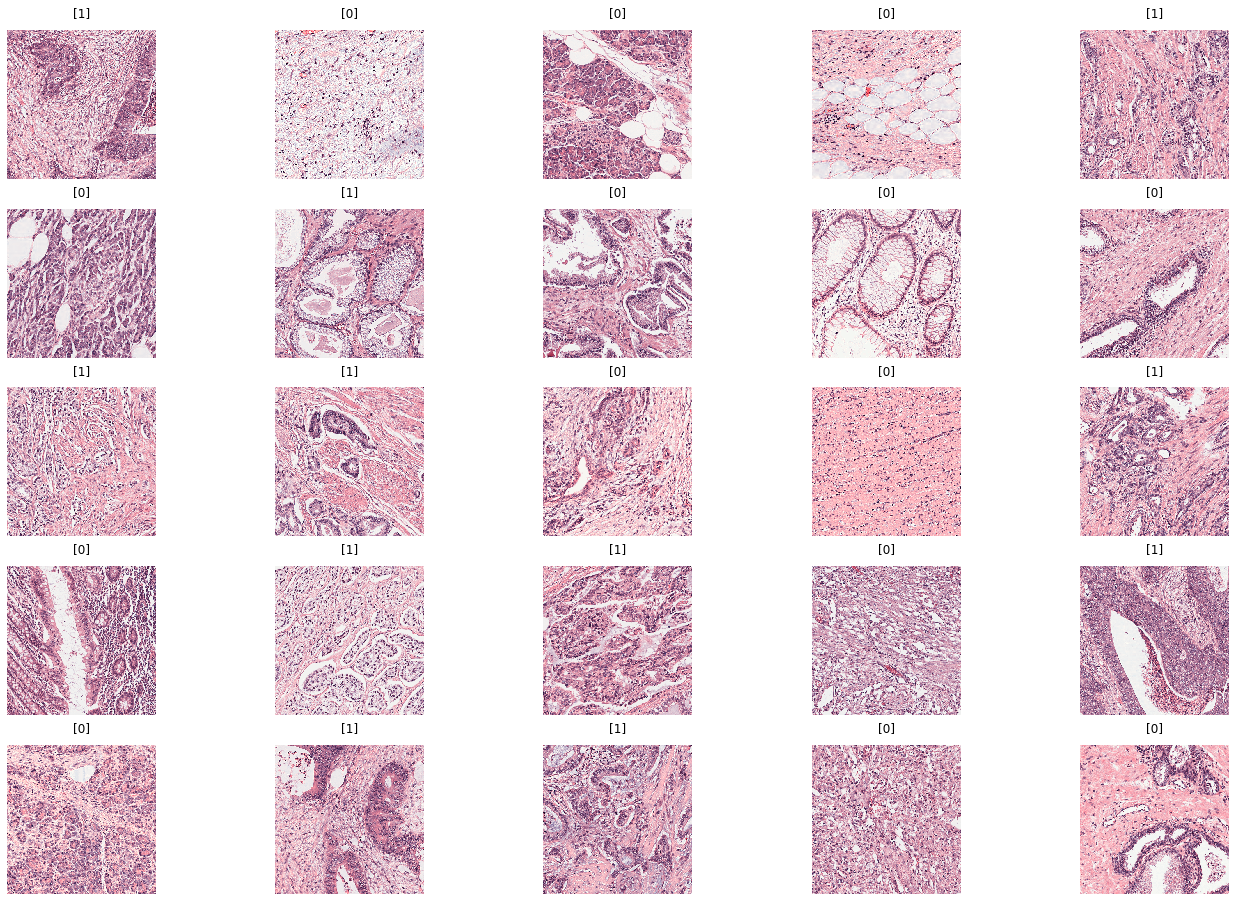

In [8]:
batch_x,batch_y = train_gen.__getitem__(31)
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        ax[i,j].matshow(batch_x[5*i+j])
        ax[i,j].set_title(batch_y[5*i+j])
        ax[i,j].axis('off')
        

In [9]:
from sklearn.utils import class_weight

In [10]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

import numpy as np
np.random.seed(1337)  # for reproducibility

# create the base pre-trained model
#base_model = InceptionV3(weights=None, include_top=False)
#base_model = InceptionV3(weights='./model/pre_trained.hdf5', include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False)

base_model.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
#x = Dense(512, activation='softmax')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)


# this is the model we will train
model = Model(base_model.input, predictions)

Using TensorFlow backend.


In [11]:
from keras.callbacks import History 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import multi_gpu_model
from livelossplot import PlotLossesKeras

plotlosses = PlotLossesKeras()

check_point = ModelCheckpoint(
    SAVE_PATH, 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='min')

reduceLROnPlat = ReduceLROnPlateau(
      monitor="val_loss",
      factor=0.1,
      patience=20,
      verbose=0,
      mode="auto",
      min_delta=0.0001,
      cooldown=5,
      min_lr=1e-7)

history = History()
#model = multi_gpu_model(model, gpus=4)
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

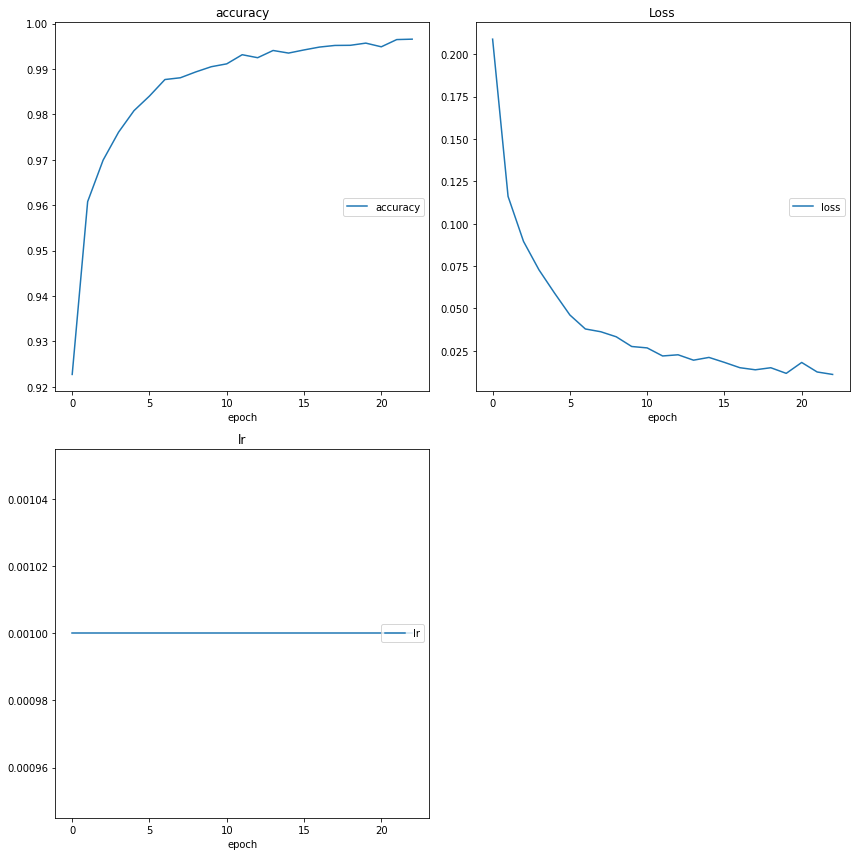

accuracy
	accuracy         	 (min:    0.923, max:    0.997, cur:    0.997)
Loss
	loss             	 (min:    0.011, max:    0.209, cur:    0.011)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
Epoch 24/200
 834/1040 [=======================>......] - ETA: 2:33 - loss: 0.0200 - accuracy: 0.9942

In [ ]:
history = model.fit(
    train_gen,
    max_queue_size = 15,
    use_multiprocessing=True,
    epochs = EPOCHS, 
    validation_data=valid_gen,
    callbacks = [check_point,reduceLROnPlat,history,plotlosses]
)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Weight load
#model.load_weights(SAVE_PATH)
#model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['Precision', 'Recall','accuracy'])
# Model evaluate

model.evaluate(test_gen,verbose=1)

353/353 [==============================] - 492s 1s/step


[0.008069892413914204, 0.9333392381668091]

In [28]:
TEST_IMG_PATH[:2]

[('/home/centos/jupyter/pathology/patch_overlap_global_512/col/0043/image/291.png',
  '/home/centos/jupyter/pathology/patch_overlap_global_512/col/0043/mask/291_p4.png'),
 ('/home/centos/jupyter/pathology/patch_overlap_global_512/pan/0037/image/251.png',
  '/home/centos/jupyter/pathology/patch_overlap_global_512/pan/0037/mask/251_p3.png')]

In [17]:
COL_IMG_PATH = [x for x in TEST_IMG_PATH if 'col' in x[0]]
PRO_IMG_PATH = [x for x in TEST_IMG_PATH if 'pros' in x[0]]
PAN_IMG_PATH = [x for x in TEST_IMG_PATH if 'pan' in x[0]]
print(len(COL_IMG_PATH),len(PRO_IMG_PATH),len(PAN_IMG_PATH))
col_gen = clf_generator(128,(512,512),COL_IMG_PATH)
pro_gen = clf_generator(128,(512,512),PRO_IMG_PATH)
pan_gen = clf_generator(128,(512,512),PAN_IMG_PATH)

2786 4382 4145


In [30]:
batch_x,batch_y = pan_gen.__getitem__(0)
Classes = ['normal', 'tumor']

In [31]:
predicted_predict = model.predict(batch_x, verbose=1)

128/128 [==============================] - 8s 60ms/step


In [32]:
predicted = predicted_predict
for i, prob in enumerate(predicted):
    if prob >=0.6:
        predicted[i] = 1
    else:
        predicted[i] = 0
        
predicted = predicted.flatten()

In [1]:
# from keras.applications.resnet50 import decode_predictions
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sn; sn.set(font_scale=1.4)
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

CM = confusion_matrix(batch_y, predicted)
print(f"Accurancy: {100*accuracy_score(batch_y, predicted):.2f}%")
print(f"Precision: {100*precision_score(batch_y, predicted):.2f}%")
print(f"Recall: {100*recall_score(batch_y, predicted):.2f}%")
print(f"F1-Score: {f1_score(batch_y, predicted):.2f}")

ax = plt.axes()
sn.heatmap(CM, annot=True, 
       annot_kws={"size": 10}, 
           xticklabels=Classes, 
           yticklabels=Classes, ax = ax, cmap="Blues", fmt='g')
ax.set_title('Confusion matrix')
plt.show()

NameError: name 'batch_y' is not defined

----------------

In [5]:
name_method_patch = 'EBV'
name_architecture = 'InceptionV3'
path_pretrained = 'None'
path_src = '/notebooks/data preparation/data_T_N' #  이거만 바꾸시면 돼요 

size_patch = [512, 512]

nb_epoch = 200

batch_size = 32

dropout = 0.5

NUM_CLASS = 2

ratio_a = 1.0
ratio_b = 1.0

class_weight = {0:ratio_a, 1:ratio_b}

In [69]:
from keras.callbacks import History 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import multi_gpu_model
from livelossplot import PlotLossesKeras

plotlosses = PlotLossesKeras()

check_point = ModelCheckpoint(
    "./model/clf_0628.hdf5", 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='min')

reduceLROnPlat = ReduceLROnPlateau(
      monitor="val_loss",
      factor=0.1,
      patience=20,
      verbose=0,
      mode="auto",
      min_delta=0.0001,
      cooldown=5,
      min_lr=1e-7)

history = History()
#model = multi_gpu_model(model, gpus=4)
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
dataset_training = len(train_generator.filenames)
dataset_valid = len(valid_generator.filenames)

print ('count of set:')
print ('dataset_training: ', dataset_training)
print ('dataset_valid: ', dataset_valid)

steps_per_epoch = (dataset_training-1) // batch_size + 1
validation_steps = (dataset_valid-1)   // batch_size + 1
print ('steps_per_epoch: ', steps_per_epoch)
print ('validation_steps: ', validation_steps)

count of set:
dataset_training:  22209
dataset_valid:  6377
steps_per_epoch:  695
validation_steps:  200


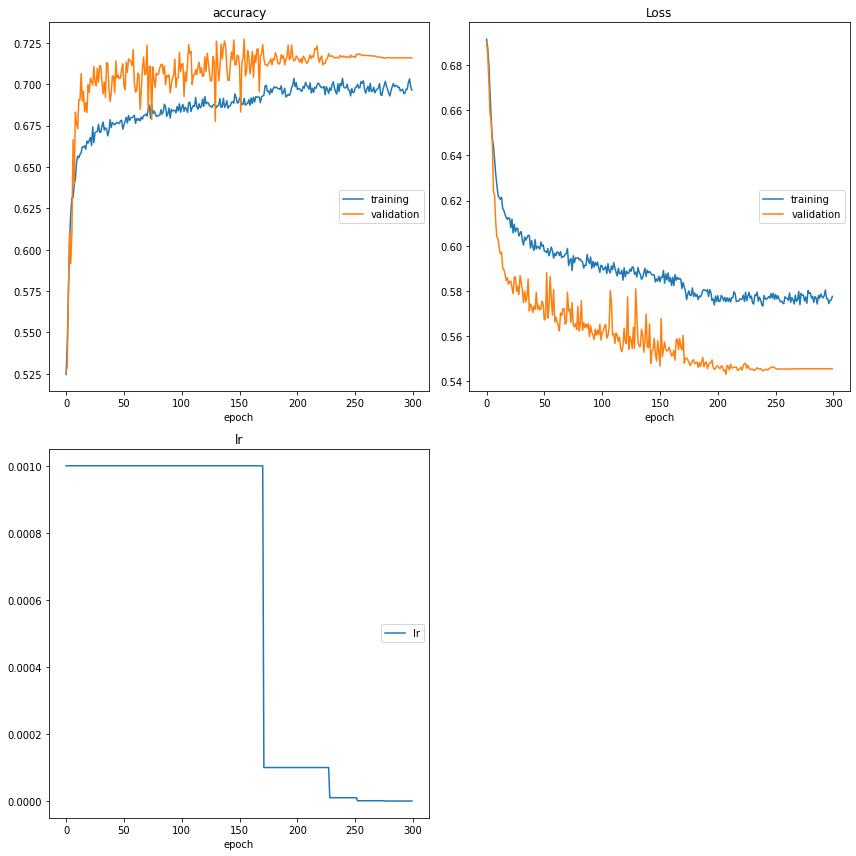

accuracy
	training         	 (min:    0.525, max:    0.704, cur:    0.697)
	validation       	 (min:    0.526, max:    0.727, cur:    0.716)
Loss
	training         	 (min:    0.573, max:    0.691, cur:    0.578)
	validation       	 (min:    0.543, max:    0.690, cur:    0.546)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
695/695 [==============================] - 1269s 2s/step - loss: 0.5776 - accuracy: 0.6966 - val_loss: 0.5456 - val_accuracy: 0.7160


In [14]:
model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=300, 
                    validation_data=valid_generator, 
                    class_weight=class_weight,
                    validation_steps=validation_steps,
                    shuffle = True,
                    callbacks = [check_point, reduceLROnPlat, history, plotlosses])

In [15]:

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   #brightness_range=[0.5,1.5],
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

test_generator = test_datagen.flow_from_directory(directory=path_src+SUBNAME_TEST,
                                                    target_size=size_patch,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    class_mode='binary')

Found 3143 images belonging to 2 classes.


In [8]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img
import random

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   
                                   brightness_range=[0.5,1.5],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=path_src+SUBNAME_TRAIN,
                                                    target_size=size_patch,
                                                    batch_size=batch_size,
                                                    class_mode='binary')

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = valid_datagen.flow_from_directory(directory=path_src+SUBNAME_VALID,
                                                              target_size=size_patch,
                                                              batch_size=batch_size,
                                                              class_mode='binary')

Found 22209 images belonging to 2 classes.
Found 6377 images belonging to 2 classes.
